In [1]:
import pandas as pd

checkins = pd.read_csv('comboframe.csv', usecols=['beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name',
                                                  'beer_style', 'beer_name',
                                                  'checkin_id'])
# only allow each user one rating for each beer
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)
print(checkins.shape)

(1894852, 9)


In [2]:
# remove the users who only checked in fewer than 4 times
checkins = checkins[checkins.user_id.map(checkins.groupby('user_id').size() > 3)]
checkins.shape

(1529580, 9)

In [3]:
# remove the beers rated fewer than 4 times
checkins = checkins[checkins.beer_id.map(checkins.groupby('beer_id').size() > 3)]
checkins.shape

(1257869, 9)

In [4]:
# remove the ones with no global ratings
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)
# and the zeros
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(1193682, 9)

In [5]:
# remove beers that aren't really beer, based on the alcohol content
checkins = checkins[(checkins.abv > 0) & (checkins.abv < 20)]
checkins.shape

(1184752, 9)

In [6]:
#checkins.to_csv('../checkins.csv')

In [6]:
# a mapping from user to number of ratings can be helpful in many situations
usercounts = checkins.groupby('user_id').size()

In [7]:
def split_last_X(frame, countDict, X):
    '''
    Split the input frame into training and testing,
    using the last X for each user as testers.
    CountDict input has the rows per user,
    and the frame is indexed by user.
    Returns the train split and test split
    '''
    boollist = [[True] * (countDict[u] - X) + [False] * X for u in frame.index.unique()]
    boollist = np.array([boo for lis in boollist for boo in lis])  # numpy to help with the logic
    
    return frame[boollist], frame[~boollist]

In [8]:
# make a func to deal with ties in rankings
def untied_rank(arr, vals):
    '''
    Measure how well the input vals (list or np.array) has chosen
    the top values of input arr (np.array). 
    vals must be subset of arr.
    1.0 is perfect, 0.0 is worst.
    '''
    fails = 0
    poss_fails = 0
    ordered = np.sort(arr)
    if max(ordered) == min(ordered): return 0.5  # like guessing
    for i in range(len(vals)):
        fails += sum(arr > vals[i])
        arr = np.delete(arr, np.where(arr == vals[i])[0][0])
        poss_fails += sum(ordered > ordered[i])
    
    return 1 - fails / poss_fails

In [9]:
import numpy as np

# with sorted checkins for each user, we can simulate having a user's rating history when recommending
checkins.sort_values(by=['user_id', 'checkin_id'], inplace=True)
checkins.set_index('user_id', inplace=True)
# gather the users who have more than 50 ratings and save their last 10 for testing
bigs = checkins.index.map(usercounts) > 49
smalls = checkins[~bigs]
tr, test = split_last_X(checkins[bigs], usercounts, 10)
train = pd.concat([smalls, tr])
print(f'{train.shape[0]} training rows, {test.shape[0]} testing rows')

1112372 training rows, 72380 testing rows


In [10]:
# need the space
checkins = None

In [11]:
from tqdm import tqdm
from collections import defaultdict

In [12]:
# show how each user's ratings deviate from global ratings and from their own ratings
train['udiff'] = train.rating_user - train.rating_global
train['udev'] = train.udiff - train.index.map(train.groupby(train.index)['udiff'].mean())

In [13]:
train.reset_index(inplace=True)
udict = {uid:dict() for uid in train.user_id.unique()}
bdict = {bid:dict() for bid in train.beer_id.unique()}
for checkin in zip(train.user_id, train.beer_id, train.udev):
    udict[checkin[0]][checkin[1]] = checkin[2]
    bdict[checkin[1]][checkin[0]] = checkin[2]

In [14]:
from scipy import stats

In [15]:
# calculate user/user correlation/similarity 
pearsons = {u: dict() for u in udict}
shared_beers = {u: defaultdict(list) for u in udict}  # track shared beers
for u in tqdm(udict):
    # loop thru all checkins by u
    for b in udict[u]:
        # loop thru all common raters
        for v in bdict[b]:
            if u < v:
                shared_beers[u][v].append(b)
                shared_beers[v][u].append(b)
                
                #combeers = [b for b in udict[u] if 2680 in bdict[bee]]

100%|██████████| 43641/43641 [08:39<00:00, 83.99it/s]   


In [18]:
def pr(u,v):
    return stats.pearsonr([udict[u][b] for b in shared_beers[u][v]],
                            [udict[v][b] for b in shared_beers[v][u]])[0]

In [21]:
min_shared = 5
for u in tqdm(udict):
    for v in shared_beers[u]:
        if u < v and len(shared_beers[u][v]) >= min_shared:
            pearsons[u][v] = pr(u, v)


100%|██████████| 43641/43641 [05:12<00:00, 139.46it/s]] 


In [26]:
# easier just to have this dict sitting by and ready to use
userbiasdict = dict(train.groupby('user_id').udiff.mean())

In [27]:
# the global rating for each beer differs slightly from checkin to checkin,
## due to accumulating stats over time.  Also I'm using each beer's listed
## global rating mean, instead of the mean of all global ratings...
beer_mu = dict(train.groupby('beer_id').rating_global.mean())

In [28]:
test.index

Int64Index([     89,      89,      89,      89,      89,      89,      89,
                 89,      89,      89,
            ...
            7245674, 7245674, 7245674, 7245674, 7245674, 7245674, 7245674,
            7245674, 7245674, 7245674],
           dtype='int64', name='user_id', length=72380)

In [29]:
test.reset_index(inplace=True)

In [25]:
def score_frame(df, beer_mu, ubias_dict, share_dict, udict, pearson_dict,
                penalty, k_most_sim, eps, min_shared, min_abs_corr):
    preds = []
    basers = []
    actual = []
    lam_4 = penalty  # higher value for this shrinks the prediction's deviation towards the global mean,
            ## especially for u-v combos with fewer common beers
    k = k_most_sim
    eps = eps  # avoids div by zero and also shrinks deviation from global mean for predictions
    min_shared_beers = min_shared  # this only starts to help around 20+, otherwise it's just noise
    min_abs_corr = min_abs_corr  # how similar or dissimilar does user v have to be to user u, in order to have a say

    for row in tqdm(zip(df.user_id, df.beer_id, df.rating_user)):
        try:
            x = row[1] # beer
            u = row[0] # user
            # before adding any tweaks, what's the baseline?
            baseline = beer_mu[x] + ubias_dict[u]  # this alone scores 0.4371 RMSE
        
            # only looking for users v who rated the beer x in question
            uv = [v for v in bdict[x] if 
                  len(share_dict[u][v]) >= min_shared_beers] # threshold for common beers rated
            
            # first get u-v pearsons
            sims = [pearson_dict[min(u,v)][max(u,v)] for v in uv]
            # then shrink in inverse relation to number of common u-v ratings
            sims = np.multiply(np.array(sims),
                               np.array([len(share_dict[u][v]) / (len(share_dict[u][v]) + lam_4) 
                                           for v in uv]))
            most_sim = sorted(list(zip(uv, sims)), reverse=True, key=lambda x: abs(x[1]))
            # take the k most similar/opposite, or all for the many short lists
            most_sim = most_sim[:min(k, len(most_sim))]
            tweaks = [udict[sim[0]][x] * sim[1] for sim in most_sim if abs(sim[1]) > min_abs_corr]
            tweak = sum(tweaks) / (len(tweaks) + eps)
            preds.append(baseline + tweak)
            basers.append(baseline)
            actual.append(row[2])
        except KeyError:
            basers.append(baseline)
            preds.append(baseline)
            actual.append(row[2])
            continue

    diffs = np.array(preds) - np.array(actual)
    rmse = np.sqrt(np.dot(diffs, diffs) / len(diffs))
    # don't really need to return rmse, since preds and actual can calculate it, but....
    return rmse, np.array(preds), np.array(basers), np.array(actual)

In [30]:
rmses = []
p_rmses = []
b_rmses = []
# start with 5 minimum common rated beers as a threshold and move up to 35
for n in range(5,36,3):
    # set epsilon, penalty, and min_abs_correlation to 0.1, for when n is higher
    rmse, preds, basers, actual = score_frame(test, beer_mu, userbiasdict, shared_beers,
                                             udict, pearsons, penalty = 1, k_most_sim=10,
                                              eps=1e-1, min_shared=n, min_abs_corr=2e-1)
    rmses.append(rmse)
    nonbase = preds != basers 
    diff_actuals = actual[nonbase]
    diff_preds = preds[nonbase]
    diff_basers = basers[nonbase]
    pred_acts = diff_preds - diff_actuals
    base_acts = diff_basers - diff_actuals
    pred_rmse = np.sqrt(np.dot(pred_acts, pred_acts) / len(pred_acts))
    p_rmses.append(pred_rmse)
    base_rmse = np.sqrt(np.dot(base_acts, base_acts) / len(base_acts))
    b_rmses.append(base_rmse)

72380it [02:17, 526.71it/s] 
72380it [00:39, 1826.46it/s]
72380it [00:42, 1702.53it/s]
72380it [00:40, 1787.36it/s]
72380it [00:44, 1617.63it/s]
72380it [00:39, 1839.12it/s]
72380it [00:38, 1870.14it/s]
72380it [00:45, 1583.80it/s]
72380it [00:36, 1961.24it/s]
72380it [00:37, 1955.56it/s]
72380it [00:39, 1814.18it/s]


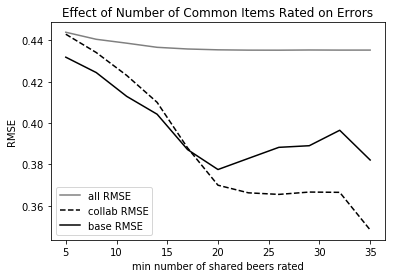

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(5,36,3), rmses, color='grey', label='all RMSE')
plt.plot(range(5,36,3), p_rmses, '--', color='k', label='collab RMSE')
plt.plot(range(5,36,3), b_rmses, color='k', label='base RMSE')
plt.xlabel('min number of shared beers rated')
plt.ylabel('RMSE')
plt.title('Effect of Number of Common Items Rated on Errors')
plt.legend()
plt.savefig('pearson_effectiveness_as_min_shared_increases.png');


In [32]:
r35, p35, b35, a35 = score_frame(test, beer_mu, userbiasdict, shared_beers,
                                             udict, pearsons, penalty = 1, k_most_sim=10,
                                              eps=1e-1, min_shared=35, min_abs_corr=1e-1)

72380it [00:45, 1594.42it/s]


In [33]:
nonbase = p35 != b35
sum(nonbase)

1326

In [34]:
u35 = test[nonbase].user_id.unique()
len(u35)

459

In [37]:
test['preds'] = p35
test['basers'] = b35

In [38]:
test35 = test.set_index('user_id').loc[u35,:]
len(test35)

4590

In [40]:
glob_scores = []
tweak_scores = []
for u in test35.index.unique():
    uten = test35.loc[u, ['rating_user','rating_global','preds']]
    glob_scores.append(untied_rank(uten.rating_user.values, 
                              uten.rating_user.values[np.argsort(uten.rating_global.values)[:-4:-1]]))
    tweak_scores.append(untied_rank(uten.rating_user.values, 
                              uten.rating_user.values[np.argsort(uten.preds.values)[:-4:-1]]))
print(f'The average score picking the top 3 globally rated for 459 "menus":  {np.mean(glob_scores)}')
print(f'The average score picking the top 3 collab rated for 459 "menus":  {np.mean(tweak_scores)}')

The average score picking the top 3 globally rated for 459 "menus":  0.796069630023786
The average score picking the top 3 collab rated for 459 "menus":  0.8040337552409789
